# Gravity compensation and impedance control

The goal of today's laboratory is to implement a gravity compensation and impedance controller.

## Instructions
Answer all the questions below and submit a pdf with detailed answers to these questions, including the plots through Brightspace. You will also need to submit the Jupyter notebooks with the code used to answer the questions.

## Robot model
Consider the following kinematic model of the robot <img src="./3d_robot_model.png" width="700">

In [1]:
#setup nice plotting
%matplotlib notebook

# we import useful libraries
import time
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

from robot_utils import getGravity

# we import the robot class
use_real_robot = True

if use_real_robot:
    from nyu_finger import NYUFingerReal    
else:
    from nyu_finger_simulator import NYUFingerSimulator
    
    
# here we define the global variables for the robot size
l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

In [2]:
# Import needed previously defined functions
def translate(vector): # vector: np.array([1,2,3])
    transform = np.eye(4)
    transform[:3,3:] = vector.reshape(3,1)
    return transform


def rotateX(angle):
    transform = np.eye(4)
    transform[1:3, 1:3] = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return transform


def rotateY(angle):
    transform = np.eye(4)
    transform[:3, :3] = np.array([[np.cos(angle), 0, np.sin(angle)], [0,1,0], [-np.sin(angle), 0, np.cos(angle)]])
    return transform


def rotateZ(angle):
    transform = np.eye(4)
    transform[:2, :2] = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return transform


def forward_kinematics(theta):
    # assume theta is a vector, theta[0] = theta0, theta[1] = theta1, etc.
    # we define the lengths of the robot
#     l0 = 0.3
#     l1 = 0.16
#     l2 = 0.16
#     l3 = 0.014

    T_SH1 = translate(np.array([l0, 0, 0]))
    T_H1H2 = rotateX(theta[0]) @ translate(np.array([0, 0, l3])) @ rotateZ(theta[1])
    T_H2K = translate(np.array([0, -l1, 0])) @ rotateZ(theta[2])
    T_KF = translate(np.array([0, -l2, 0]))
    
    T_SF = T_SH1 @ T_H1H2 @ T_H2K @ T_KF
    
    return T_SF

def adjoint(T):
    ''' Gives the adjoint(6x6) of a transformation matrix'''
    AdT = np.zeros((6,6))
    R = T[:3, :3]
    p = T[:3, 3]
    AdT[:3, :3] = R
    AdT[3:6, 3:6] = R
    AdT[3:6, :3] = vec2skewsym(p) @ R
    return AdT

def vec2skewsym(array):
    ''' Bracket notation'''
    a_skew = np.zeros((3,3))
    a_skew[2][1], a_skew[1][2] = array[0], -array[0]
    a_skew[0][2], a_skew[2][0] = array[1], -array[1]
    a_skew[1][0], a_skew[0][1] = array[2], -array[2]
    return a_skew


def compute_jacobian(theta):
    J = np.zeros([3,3])

    # First, we can calculate Jacobian in spacial frame
    T_SH1 = translate(np.array([l0, 0, 0]))
    T_H1H2 = rotateX(theta[0]) @ translate(np.array([0, 0, l3])) @ rotateZ(theta[1])
    T_H2K = translate(np.array([0, -l1, 0])) @ rotateZ(theta[2])
    T_KF = translate(np.array([0, -l2, 0]))
    

    # Getting Jacobian of each joint and stack horizontally
    w_H1 = np.array([[1,0,0,0,0,0]])
    J1_S = adjoint(T_SH1) @ w_H1.T

    w_H2 = np.array([[0,0,1,0,0,0]])
    J2_S = adjoint(T_SH1 @ T_H1H2) @ w_H2.T
 
    w_K = np.array([[0,0,1,0,0,0]])
    J3_S = adjoint(T_SH1 @ T_H1H2 @ T_H2K) @ w_K.T
    
    J_S = np.hstack([J1_S, J2_S, J3_S])
    
    
    # Get transformation matrix of O in spacial frame
    T_SO = forward_kinematics(theta)
    T_SO[:3, :3] = np.zeros(3)
    T_OS = np.eye(4)
    T_OS[:3, 3] = -T_SO[:3, 3]

    
    # Convert from J_S to J_O
    J_O = np.zeros([3,3])
    J_O = adjoint(T_OS) @ J_S
    
    J = J_O[3:,:]

    return J

def diagonal(x, y, z):
    return np.array([[x, 0, 0],
                     [0, y, 0],
                     [0, 0, z]])

# 1 Gravity compensation

You are provided with a function ``getGravity(q)`` which takes as an input an array of joint angles and returns the corresponding gravity vector (3 dimensional) G(q) that appears in the equation of motion of a robot
$$M \ddot{q} + C(q,\dot{q})\cdot \dot{q} + G(q) = \tau$$

## Questions
1. Use this function to add gravity compensation to the PD controller implemented below. Compare the performance of the control with and without gravity compensation (in terms of quality of joint tracking)
2. Test the controllers on the real robot and plot the same plots as for the simulation

# 2 Impedance control

Last laboratory, we used the inverse of the Jacobian to control the finger position and move it in arbitrary directions.
We were inverting the relationship $\dot{p}_{finger} = J \dot{\theta}$ to compute the desired velocity of the joint given a desired velocity of the finger.

In this laboratory, we will revisit direct control of the finger, this time using the relationship $\tau = J^T F_{finger}$, where $\tau$ is the vector of motor torques and $F_{finger}$ the 3D force at the end-effector.
For a desired force $F_{pos}$, we can directly compute the required motor torques $\tau$ without the need to compute
any inverse. We will use this relationship to move the finger.

Assume we want the finger to behave as if springs and dampers were attached to it, as shown in this figure
![](./spring_schematics.png)

Consider the $x$ direction. An ideal spring will have a stiffness $K_x$ and a rest position $x_0$. Therefore, we should see a force pushing or pulling the finger according to $F_x = K_x (x_0 - x_{measured})$, where $x_{measured}$ is the measured position of the finger (make sure that $x_0$ and $x_{measured}$ are expressed in the same coordinate frame!)

In 3D, setting the rest position to $p_0 = [x_0, y_0, z_0]^T \in \mathbb{R}^3$, we will have a force $$F = K (p_0 - p_{measured})$$
where where $p_{measured}$ is the measured position of the finger in 3D and $K$ is a diagonal gain matrix that contains the stiffnesses of the 3 springs one its diagonal, i.e. 
$$K = \begin{bmatrix} K_x & 0 & 0 \\ 0 & K_y & 0 \\ 0 & 0 & K_z \end{bmatrix}$$

To implement this behavior, one can simply set the torques on the motors of the robot as
$$ \tau = J_{Ov}^T K (p_0 - p_{measured})$$ The leg will then behave like a spring.
Note here that we are only using the bottom three rows of the Jacobian, as we are only interested in the force and not the moments (which we ignore).

In addition to a spring, it is often a good idea to have a damper, that will dampen out any oscillations of the spring such that the leg can reach its rest position $p_0$ (otherwise it would oscillate forever). We can then also add a force conteracting velocity of the finger as
$-D \dot{p}_{measured}$, where $D$ is a diagonal matrix that contains the damping gains for each spring.

The resulting controller is then
$$\tau = J_{Ov}^T \Big( K (p_0 - p_{measured}) - D \dot{p}_{measured} \Big)$$

If one wants to track desired setpoint positions (e.g. a trajectory of setpoints) and maybe also a desired velocity,
we can easily adapt the impedance controller as follows
$$\tau = J_{Ov}^T \Big( K (p_{ref}(t) - p_{measured}) + D (\dot{p}_{ref}(t) - \dot{p}_{measured}) \Big)$$
where $p_{ref}(t)$ is a reference trajectory of set points. Note here how this resembles a PD controller in the end-effector space.


## Questions
1. Write an impedance controller with a constant stiffness $K_x = K_z = 50$ and $K_y = 10$ and with damping only in the x,z direction ($D_x = D_z = 5$, $D_y = 0$) so the vertical direction will behave like a ideal spring.
Set $p_0 = [0.3, -0.2, 0.014]$. Add gravity compensation to the controller as well. Plot the position of the end-effector and its velocity as a function of time. Does it behave as expected? (make sure you start the robot with initial configuration $q=[0,0,0]$).
2. Redo the same experiment when adding damping in the y direction $D_y = .1$ and then again with $D_y = 1$. Plot again the end-effector positions and velocities, what do you notice different? (make sure you start the robot with initial configuration $q=[0,0,0]$).
3. Write an impedance controller that can draw a circle in the x-y plane. We would like to follow the 3D finger trajectory $$x_{ref}(t) = \begin{pmatrix} 0.3 + 0.05\cos(\omega t) \\ -0.2 + 0.05 \sin(\omega t) \\ 0 \end{pmatrix}$$
where $\omega = \pi$ is the frequency of rotation around the circle (frequency of rotation of $0.5Hz$).
Use $K = \text{Diag}([50,50,50])$ and $D = \text{Diag}([5,5,5])$. Plot the desired and measured positions of the finger as well as the desired and measured velocities of the finger. Compare your results with what you did in Lab5. What are the pros and cons of both methods?
4. Test the controller(s) on the real robot and perform the same analysis.

In [3]:
if use_real_robot:
    # Triggers the real robot
    # Don't forget to turn on the robot first !!!
    robot = NYUFingerReal()
    # Make sure that the motor number matches that on the robot
    motor_number = np.array([3,2,0])
    robot.initialize('ens1', motor_number)
else:
    # we can now create a robot simulation
    robot = NYUFingerSimulator()

# we reset the simulation
if not use_real_robot:
    robot.reset_state([0,0,0.2])
#     robot.reset_state([0,0,0])
else:
    # we wait
    for i in range(7500):
        robot.send_joint_torque(np.zeros([3,1]))
        robot.step()

    
# we simulate for 6 seconds (2 seconds per goal)
run_time = 10.
dt = 0.001
num_steps = int(run_time/dt)

# the PD gains
P = np.array([1.5, 1.5, 1.5])
D = np.array([0.05, 0.05, 0.05])

## we allocate a few vectors to collect data while we do the simulation
# we will store the sensor values (angular position and velocities)
measured_positions = np.zeros([num_steps,3])
measured_velocities = np.zeros_like(measured_positions)
# we will store the commands sent to the robot
desired_torques = np.zeros_like(measured_positions)
# we will store the desired joint trajectories that the PD controller follows
desired_positions = np.zeros_like(measured_positions)
desired_velocities = np.zeros_like(measured_positions)
# we keep track of time
time = np.zeros([num_steps])
# we will store the end effector position (desired and measured)
measured_finger_positions = np.zeros([num_steps,3])
measured_finger_velocities = np.zeros([num_steps,3])
desired_finger_position = np.zeros([num_steps,3])


for i in range(num_steps):
    # get the current time and save it
    time[i] = dt * i
    
    # we get the position and velocities of the joints
    q, dq = robot.get_state()
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq
    
    # save the current position of the finger using the FK function
    pose = forward_kinematics(q)
    measured_finger_positions[i,:] = pose[0:3,3]
    if i > 0: # Get rid of first iter
        measured_finger_velocities[i,:] = (measured_finger_positions[i,:] - measured_finger_positions[i-1,:])/dt
    
    # controller: TODO HERE IMPLEMENT YOUR CONTROLLER
    '''Q1'''

#     # this is the desired trajectory for Question 1 - this needs to be removed for Question 2
#     q_des = np.array([0, 0.5 - 0.5 * np.cos(2*time[i]), 0.5 * np.cos(2*time[i])])
#     dq_des = np.array([0, 2 * 0.5 * np.sin(2*time[i]), -2 * 0.5 * np.sin(2*time[i])])

#     # we save the desired positions/velocities for later plotting 
#     desired_positions[i,:] = q_des
#     desired_velocities[i,:] = dq_des
    
#     # PD controller
#     error = q_des - q # the position error for all the joints (it's a 3D vector)
#     d_error = dq_des-dq # the velocity error for all the joints
    
#     # we compute the desired torques as a PD controller
#     joint_torques = P * error + D * d_error #+ getGravity(q)

    '''Q2.1'''
#     Kx, Ky, Kz = 100, 20, 100
#     Dx, Dy, Dz = 1, 0, 1
#     K = diagonal(Kx, Ky, Kz)
#     D = diagonal(Dx, Dy, Dz)
#     p0 = np.array([0.3,-0.2,0.014])
    
    
    '''Q2.2.1'''
#     Dy = 0.1
#     D = diagonal(Dx, Dy, Dz)
    
    '''Q2.2.2'''
#     Dy = 1
#     D = diagonal(Dx, Dy, Dz)
#     joint_torques = compute_jacobian(q).T @ (K @ (p0 - measured_finger_positions[i,:]) - D @ (measured_finger_velocities[i,:])) + getGravity(q)

    '''Q2.3'''
    Kx, Ky, Kz = 42,42,42
    Dx, Dy, Dz = 0.2, 0.2,0.2
    K = diagonal(Kx, Ky, Kz)
    D = diagonal(Dx, Dy, Dz)
    omega = np.pi
    x_ref = [0.3 + 0.01 * np.cos(omega * time[i]),
            -0.2 + 0.01 * np.sin(omega * time[i]),
             0]

    dx_ref = [-0.01 * omega * np.sin(omega * time[i]),
               0.01 * omega * np.cos(omega * time[i]),
               0]
    
    joint_torques = compute_jacobian(q).T @ (K @ (x_ref - measured_finger_positions[i,:]) + D @ (dx_ref - measured_finger_velocities[i,:])) + getGravity(q)
    desired_torques[i,:] = joint_torques
    
    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    robot.step()

<IPython.core.display.Javascript object>


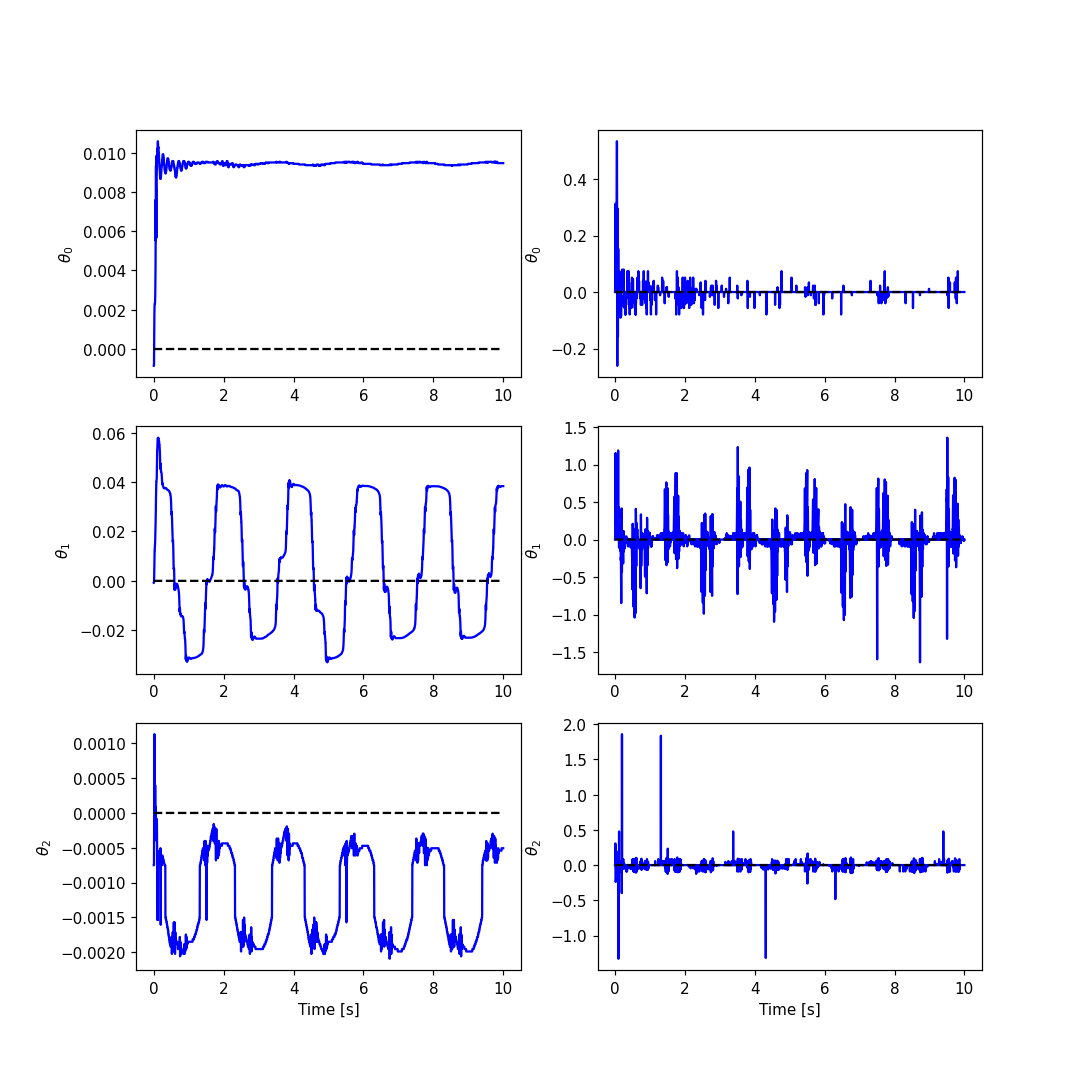

In [4]:
def plot_joint_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, th[:,0], 'b-', time, th_des[:,0], '--k')
    plt.ylabel(r'$\theta_0$')
    plt.subplot(3,2,3)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'$\theta_1$')
    plt.subplot(3,2,5)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'$\theta_2$')
    plt.xlabel('Time [s]')
    
    plt.subplot(3,2,2)
    plt.plot(time, dth[:,0], 'b-', time, dth_des[:,0], '--k')
    plt.ylabel(r'$\dot{\theta}_0$')
    plt.subplot(3,2,4)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'$\dot{\theta}_1$')
    plt.subplot(3,2,6)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'$\dot{\theta}_2$')
    plt.xlabel('Time [s]')
    
plot_joint_posvel(time, measured_positions, desired_positions, measured_velocities, desired_velocities)

In [5]:
def plot_finger_trajectory(finger_position):
    """
    plots the position of the finger in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.plot(finger_position[:,0],finger_position[:,1], 'b')
    plt.xlabel('finger x position [m]')
    plt.ylabel('finger y position [m]')
    plt.xlim([-l1-l2+l0-0.05,l0+l1+l2+0.05])
    plt.ylim([-l1-l2-0.05, l1+l2+0.05])
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')
    

plot_finger_trajectory(measured_finger_positions)

<IPython.core.display.Javascript object>